In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from tqdm import tqdm
from keras.utils import np_utils
from imgaug import augmenters as iaa
import helpers

Using TensorFlow backend.


In [2]:
#Root directory of the project
ROOT_DIR = os.path.abspath(".")
# Training file directory
dataset_path = os.path.join(ROOT_DIR, 'dataset', 'ISIC2016')
model_path = os.path.join(ROOT_DIR, "models")
dataset_path

'C:\\Users\\Hasib\\Desktop\\works\\lesion-learnt\\dataset\\ISIC2016'

In [3]:
# load data
cancer = np.load("{}/cancer.npy".format(dataset_path))
non_cancer = np.load("{}/non_cancer.npy".format(dataset_path))

cancer.shape, non_cancer.shape

((173, 299, 299, 3), (727, 299, 299, 3))

In [4]:
cancer_label = np.array([1 for _ in range(len(cancer))])
non_cancer_label = np.array([0 for _ in range(len(non_cancer))])

cancer_label.shape, non_cancer_label.shape

((173,), (727,))

In [5]:
# Balance dataset

seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

seq_standard = iaa.Sequential([
    iaa.Fliplr(0.5), 
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-25, 25))
], random_order=True)


def augment_data_minimal( x_values, y_values ):
    counter = 0
    RESIZE_DIM = 299
    X_values_augmented = []
    Y_values_augmented = []
    for x in x_values:
        for p in range(4):
            
            # seq 1
            Y_values_augmented.append( y_values[counter] )
            images_aug = seq_standard.augment_images(x.reshape(1,RESIZE_DIM,RESIZE_DIM,3))   
            X_values_augmented.append( images_aug.reshape(RESIZE_DIM,RESIZE_DIM,3))
            
        counter = counter + 1
    
    # Quick math!
    # prev number of images = n
    # augmented number of images = n * 4 ( 2 seq 2 times)
    
    X_values_augmented = np.asarray( X_values_augmented )
    Y_values_augmented = np.asarray( Y_values_augmented )
    return (X_values_augmented, Y_values_augmented)


In [11]:
(x_aug, y_aug) = augment_data_minimal( cancer, cancer_label)
x_aug.shape, y_aug.shape

((692, 299, 299, 3), (692,))

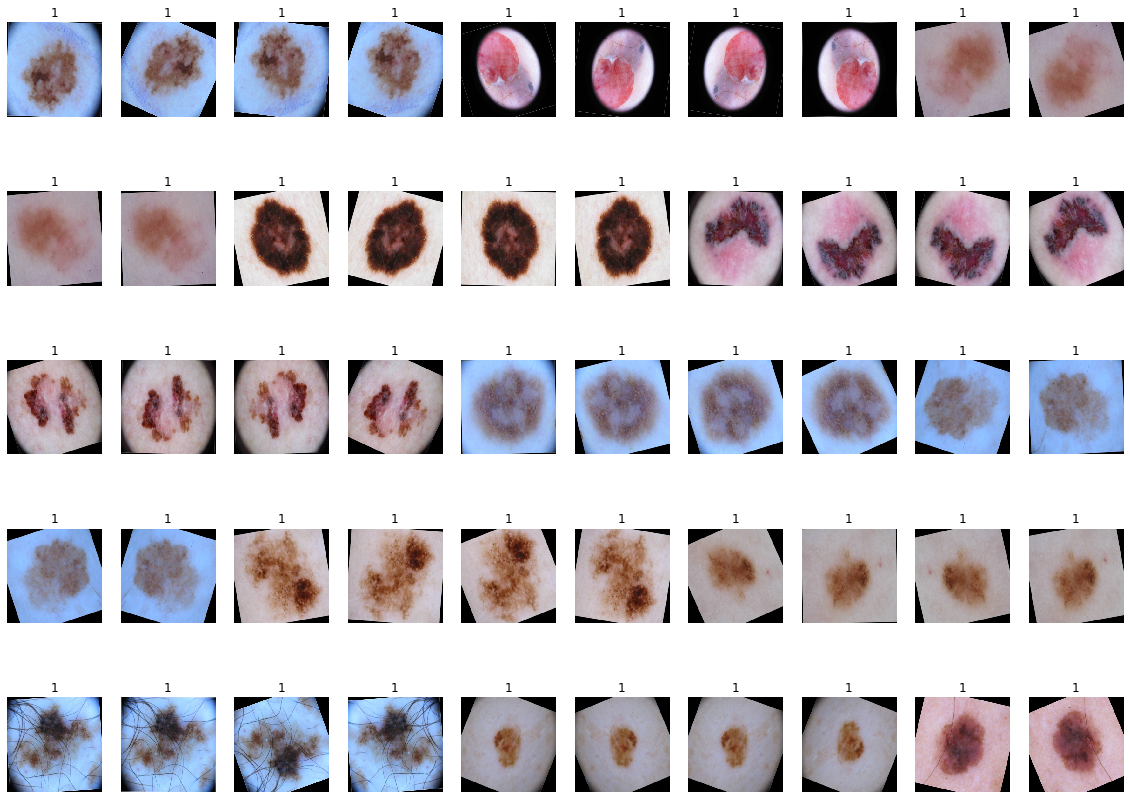

In [12]:
helpers.imshow_group(x_aug[:50], y_aug[:50])

In [13]:
cancer_aug = np.concatenate( (cancer, x_aug), axis = 0)
cancer_label_aug = np.concatenate( (cancer_label, y_aug), axis = 0)

# new normal samples
cancer_aug.shape, cancer_label_aug.shape

((865, 299, 299, 3), (865,))

In [14]:
cancer_aug.shape, non_cancer.shape

((865, 299, 299, 3), (727, 299, 299, 3))

In [19]:
x_all = np.concatenate((cancer_aug, non_cancer), axis=0)
y_all = np.concatenate((cancer_label_aug, non_cancer_label), axis=0)
print(x_all.shape, y_all.shape)

(1592, 299, 299, 3) (1592,)


In [20]:
# one hot encoded vectors
num_classes = 2
y_all = np_utils.to_categorical(y_all,2)
print(y_all.shape)

(1592, 2)


In [21]:
flat = np.array([np.argmax(pred) for pred in y_all])
np.count_nonzero(flat == 1), np.count_nonzero(flat == 0)

(865, 727)

In [22]:
np.save("dataset/ISIC2016/x_baln.npy", x_all)
np.save("dataset/ISIC2016/y_baln.npy", y_all)
print("Done!")

Done!
